In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50

# 1. X-y split

In [3]:
from scipy.stats import zscore

In [4]:
# filter the dataframe to remove the outliers
def remove_outliers(num_df):
    z = num_df.apply(zscore)
    threshold = 3
    num_df = num_df[(z < threshold).all(axis=1)]
    return num_df

In [5]:
# load the data with dummies and ordinally encoded categorical data and then load the numerical data
# define numerical and categorical Xs and target feature y

X = pd.read_csv("Data_Marketing_Customer_Analysis_Round3.csv")
categoricalX = X.select_dtypes(object).drop("effective_to_date",axis=1)

categoricalX = pd.read_csv("dum_df.csv")

numericalX = pd.read_csv("num_df.csv")
y = numericalX["total_claim_amount"]
numericalX = numericalX.drop("total_claim_amount", axis=1)

X = pd.concat([categoricalX, numericalX], axis=1)

# 2. Test - train split

In [6]:
RAND_STATE = 34 # for reproducible shuffling
TT_RATIO = 0.3 # test/train

In [7]:
# test-train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TT_RATIO, random_state=RAND_STATE)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
X_train.head(10)

,coverage,education,vehicle_size,east,north west,west region,yes,jan,employed,medical leave,...,sports car,suv,two-door car,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
2705,0,1,1,0,0,0,0,1,1,0,...,0,0,0,4786,45515,61,10,33,0,9
2209,0,1,1,0,0,0,0,0,0,0,...,0,0,0,22445,80340,71,32,35,0,2
4004,1,1,1,0,0,1,0,1,1,0,...,0,0,0,6412,58776,83,20,50,2,4
1898,0,1,1,1,0,0,0,1,0,0,...,0,0,0,2254,48978,65,7,95,0,1
10016,1,1,1,0,0,1,0,1,1,0,...,0,0,1,7427,28848,96,22,54,0,7
3098,0,1,0,0,0,1,0,1,1,0,...,0,0,1,7579,33906,64,25,49,0,2
1327,1,0,1,0,0,1,0,0,1,0,...,0,0,0,3399,28928,87,23,7,1,1
7903,1,1,1,1,0,0,0,1,1,0,...,0,1,0,10990,44552,137,7,42,0,3
7108,0,0,1,0,1,0,0,1,1,0,...,0,1,0,12375,78441,103,6,73,0,2
5142,0,0,1,0,0,1,1,1,1,0,...,0,0,0,5639,73168,70,21,50,0,3


# 3. Standardize data

In [14]:
# using the ColumnTransformer to transform the numerical columns with the PowerTransformer
pt = PowerTransformer()

ct = ColumnTransformer([("pt", pt, list(X.columns))],
                        remainder='drop',verbose_feature_names_out=True,verbose=True).fit(X_train)
X_train_ct = pd.DataFrame(ct.transform(X_train),columns=ct.get_feature_names_out())
X_test_ct = pd.DataFrame(ct.transform(X_test),columns=ct.get_feature_names_out())

[ColumnTransformer] ............ (1 of 1) Processing pt, total=   1.2s


In [15]:
X_train_ct

,pt__coverage,pt__education,pt__vehicle_size,pt__east,pt__north west,pt__west region,pt__yes,pt__jan,pt__employed,pt__medical leave,...,pt__sports car,pt__suv,pt__two-door car,pt__customer_lifetime_value,pt__income,pt__monthly_premium_auto,pt__months_since_last_claim,pt__months_since_policy_inception,pt__number_of_open_complaints,pt__number_of_policies
0,-0.799409,0.332813,0.150382,-0.314388,-0.630651,-0.723975,-0.383659,0.925265,0.775536,-0.216501,...,-0.233868,-0.495527,-0.505757,-0.340765,-0.143033,-1.552039,-0.350352,-0.428756,-0.502522,1.660057
1,-0.799409,0.332813,0.150382,-0.314388,-0.630651,-0.723975,-0.383659,-1.080772,-1.289431,-0.216501,...,-0.233868,-0.495527,-0.505757,1.732220,1.108667,-0.712384,1.463437,-0.354308,-0.502522,-0.063268
2,1.145812,0.332813,0.150382,-0.314388,-0.630651,1.381264,-0.383659,0.925265,0.775536,-0.216501,...,-0.233868,-0.495527,-0.505757,0.142838,0.372284,-0.020814,0.582646,0.170412,2.032405,0.875803
3,-0.799409,0.332813,0.150382,3.180784,-0.630651,-0.723975,-0.383659,0.925265,-1.289431,-0.216501,...,-0.233868,-0.495527,-0.505757,-1.841641,-0.002560,-1.178270,-0.700972,1.525083,-0.502522,-1.143833
4,1.145812,0.332813,0.150382,-0.314388,-0.630651,1.381264,-0.383659,0.925265,0.775536,-0.216501,...,-0.233868,-0.495527,1.977233,0.367618,-0.900458,0.496901,0.742711,0.302193,-0.502522,1.454127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7477,1.145812,0.332813,-1.685971,-0.314388,1.585663,-0.723975,-0.383659,-1.080772,-1.289431,-0.216501,...,-0.233868,-0.495527,-0.505757,0.199678,-0.194957,0.593059,0.240451,0.650895,2.032405,0.513168
7478,1.545906,0.332813,-1.685971,-0.314388,-0.630651,1.381264,-0.383659,0.925265,-1.289431,-0.216501,...,-0.233868,-0.495527,1.977233,0.928730,-0.082468,0.938141,0.971550,0.773350,-0.502522,-0.063268
7479,-0.799409,-1.393362,0.150382,-0.314388,-0.630651,1.381264,-0.383659,-1.080772,0.775536,-0.216501,...,-0.233868,-0.495527,-0.505757,-1.511516,1.656755,-1.178270,-0.040648,-0.428756,-0.502522,-1.143833
7480,1.145812,0.332813,0.150382,-0.314388,-0.630651,-0.723975,-0.383659,0.925265,0.775536,-0.216501,...,-0.233868,-0.495527,-0.505757,-0.980688,-1.203165,0.200536,-0.461825,-1.644616,2.032405,-1.143833


# 4. Apply linear regression

## 4.1 OLS

In [16]:
X_train_const_ct = sm.add_constant(X_train_ct.to_numpy()) # adding a constant

model_ct = sm.OLS(y_train, X_train_const_ct).fit()
# predictions_train = model.predict(X_train_const_ct)

X_test_const_ct = sm.add_constant(X_test_ct) # adding a constant
predictions_test = model_ct.predict(X_test_const_ct)
print_model = model_ct.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     total_claim_amount   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     491.0
Date:                Thu, 02 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:29:02   Log-Likelihood:                -48041.
No. Observations:                7482   AIC:                         9.617e+04
Df Residuals:                    7438   BIC:                         9.647e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        435.8295      1.724    252.786      0.0

# Model evaluation

NameError: name 'y_pred_ct' is not defined

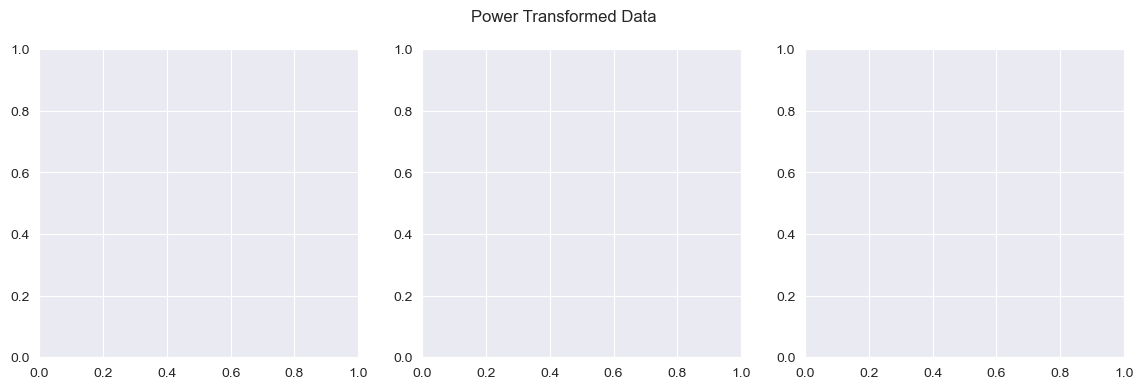

In [12]:
# PLOTS FOR POWER TRANSFORMED DATA
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,3,figsize=(14,4))
fig.suptitle("Power Transformed Data")
ax[0].plot(y_pred_ct, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set - Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscedasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred_ct)
ax[1].set_xlabel("Test y - y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred_ct,y_pred_ct.to_numpy() - y_test,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred_ct,np.zeros(len(y_pred_ct)),linestyle='dashed')